INSA ROUEN <br>
MS ESD 2019-2020 <br>
Winnie VORIHILALA <br>

# <center>  TP 1 - Systèmes de recommendation </center>

Ce TP vise à montrer comment construire un système de recommandation simple sur un ensemble de données de films notés.

# Exercice 1 - SVD et SVD pondérées sur les données Movie Lens

# Question 1 : Jeu de données The Movie Lens 100k

a) Le jeu de donnée MovieLens 100K Dataset a été collecté par le GroupLens Research Project à l'Université du Minnesota (dataset disponible sur ce <a href="https://grouplens.org/datasets/movielens/100k/">lien)</a>. <br>
 
Ce jeu de données comprend:
* 100 000 notes (1-5) de 943 utilisateurs sur 1682 films.
* Chaque utilisateur a évalué au moins 20 films.

Les données ont été collectées via le site Web MovieLens(movielens.umn.edu) pendant une période de 7 mois à compter du 19 septembre 1997 jusqu'au 22 avril 1998. Ces données ont été nettoyées et les utilisateurs qui avaient moins de 20 notes ou n'avaient pas de données démographiques complètes ont été supprimées de cet ensemble de données.

b) Il est préférable de commencer avec un jeu de données comme The MovieLens 100k pour éviter des problèmes tels que : <br>
- le dépassement de mémoire (si le jeu de données est trop gros)
- une lenteur d'execution des calculs et du code si on ne dispose pas d'un bon processeur


c) Téléchargement du jeu de données 

## c1 - Chargement des librairies

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import random
from datetime import datetime
import plotly.express as px
import scipy
import scipy.sparse
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.sparse.linalg import svds, eigs

import plotly.graph_objs as go
import plotly as py
import plotly
py.offline.init_notebook_mode()

## c2 - Chargement des données

In [3]:
dateparse = lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S') #mettre timestamp au bon format date

# Dans le cadre du sujet de TP, c'est u.data qui nous intéresse
rating_df = pd.read_csv('/Users/winnievorihilala/Documents/INSA/Systeme_de_recommandation/ml-100k/u.data', sep='\t', 
                        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
                        parse_dates=['timestamp'], 
                        date_parser=dateparse)

# Chargons néanmoins u.item et u.user afin de mieux visualiser l'ensemble du jeu de données movieLens 100k
movie_df = pd.read_csv('/Users/winnievorihilala/Documents/INSA/Systeme_de_recommandation/ml-100k/u.item', sep='|', encoding='latin-1',
                    names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action', 
                           'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 
                           'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'])

user_df = pd.read_csv('/Users/winnievorihilala/Documents/INSA/Systeme_de_recommandation/ml-100k//u.user', sep='|', encoding='latin-1',
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

print(rating_df.shape)
print(movie_df.shape)
print(user_df.shape)

(100000, 4)
(1682, 24)
(943, 5)


## Exploratory Data Analysis (EDA)

In [13]:
rating_df.sample(10) #tirage aléatoire de 10 lignes du dataframe rating_df pour visualisation

user_id  movie_id  rating           timestamp
83412      730       535       2 1997-11-23 18:41:46
69522      782      1528       2 1998-04-02 06:46:17
24985      429       549       4 1997-12-17 19:09:09
79034      481       199       5 1998-01-26 15:29:03
72164      504       216       4 1998-02-18 21:47:30
59243      300      1094       5 1997-09-30 20:11:38
35345      425      1419       3 1997-11-05 14:05:57
66898      693       174       4 1997-09-28 21:58:01
96964      908       264       3 1997-11-16 23:16:46
52945      152       155       5 1998-01-05 16:39:50

In [14]:
rating_df.head()

user_id  movie_id  rating           timestamp
0      196       242       3 1997-12-04 15:55:49
1      186       302       3 1998-04-04 19:22:22
2       22       377       1 1997-11-07 07:18:36
3      244        51       2 1997-11-27 05:02:03
4      166       346       1 1998-02-02 05:33:16

In [15]:
#rating_df.user_id.sort_values(ascending=True) //tri croissant sur la colonne user_id pour visualisation 

In [16]:
user_df.head()

user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213

In [17]:
movie_df.head()

movie_id        movie_title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            imdb_url  unknown  action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   adventure  animation  childrens  ...  fantasy  film_noir  horror  musical  \
0          0          1          1  ...        0          0       0        0   
1          1          0          0  ...        0          0       0        0   
2          0          0          0  ...        0          0       0        0   
3          0          0          0  ...        0          0       0        0   
4          0          0          0  ...        0          0       0        0   

   mystery  romance  sci_fi  thriller  war  western  
0        0        0       0         0    0        0  
1        0        0       0         1    0        0  
2        0        0       0         1    0        0  
3        0        0       0         0    0        0  
4        0        0       0         1    0        0  

[5 rows x 24 columns]

On constate que la date de la colonne release_date n'est pas au bon format.

In [18]:
#mettre la date au bon format
movie_df.release_date = pd.to_datetime(movie_df.release_date) 
movie_df.head()

movie_id        movie_title release_date  video_release_date  \
0         1   Toy Story (1995)   1995-01-01                 NaN   
1         2   GoldenEye (1995)   1995-01-01                 NaN   
2         3  Four Rooms (1995)   1995-01-01                 NaN   
3         4  Get Shorty (1995)   1995-01-01                 NaN   
4         5     Copycat (1995)   1995-01-01                 NaN   

                                            imdb_url  unknown  action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   adventure  animation  childrens  ...  fantasy  film_noir  horror  musical  \
0          0          1          1  ...        0          0       0        0   
1          1          0          0  ...        0          0       0        0   
2          0          0          0  ...        0          0       0        0   
3          0          0          0  ...        0          0       0        0   
4          0          0          0  ...        0          0       0        0   

   mystery  romance  sci_fi  thriller  war  western  
0        0        0       0         0    0        0  
1        0        0       0         1    0        0  
2        0        0       0         1    0        0  
3        0        0       0         0    0        0  
4        0        0       0         1    0        0  

[5 rows x 24 columns]

In [19]:
# La fonction ci-dessous cherche les valeurs nan de chaque colonne du dataframe donné en argument, et affiche leur quantité en pourcentage

def check_nan_percent(df): 
    columns_null_count = df.isnull().sum()
    null_percent_df = pd.DataFrame({'null_percent': (columns_null_count/df.shape[0])*100, 'total_null': columns_null_count})
    return null_percent_df[null_percent_df.null_percent>0]

print(check_nan_percent(rating_df))
print(check_nan_percent(movie_df))
print(check_nan_percent(user_df))

Empty DataFrame
Columns: [null_percent, total_null]
Index: []
                    null_percent  total_null
release_date            0.059453           1
video_release_date    100.000000        1682
imdb_url                0.178359           3
Empty DataFrame
Columns: [null_percent, total_null]
Index: []


On constate que le dataframe rating_df et user_df ne contiennent aucune valeur manquante NAN. En revanche, movie_df contient 0,06% de valeurs manquantes dans la colonne release_date, 0,17% de valeurs manquantes dans la colonne imdb_url, et 100% de valeurs manquantes dans la colonne video_release_date.

In [20]:
user_df.user_id = user_df.user_id - 1
movie_df.movie_id = movie_df.movie_id - 1

In [21]:
# Jointures sur les dataframes
rating_user_df = rating_df.join(other=user_df, how='inner', on='user_id', lsuffix='_R')
rating_user_movie_df = rating_user_df.join(other=movie_df, how='inner', on='movie_id', rsuffix='_M')
rating_movie_df = rating_df.join(other=movie_df, how='inner', on='movie_id', rsuffix='_M')
rating_user_df.head()

user_id_R  movie_id  rating           timestamp  user_id  age gender  \
0           196       242       3 1997-12-04 15:55:49      196   55      M   
940         196       393       4 1997-12-04 16:11:03      196   55      M   
1133        196       381       4 1997-12-04 16:08:48      196   55      M   
1812        196       251       3 1997-12-04 16:01:14      196   55      M   
1896        196       655       5 1997-12-04 16:09:53      196   55      M   

      occupation zip_code  
0     technician    75094  
940   technician    75094  
1133  technician    75094  
1812  technician    75094  
1896  technician    75094

In [22]:
rating_user_df.head()

user_id_R  movie_id  rating           timestamp  user_id  age gender  \
0           196       242       3 1997-12-04 15:55:49      196   55      M   
940         196       393       4 1997-12-04 16:11:03      196   55      M   
1133        196       381       4 1997-12-04 16:08:48      196   55      M   
1812        196       251       3 1997-12-04 16:01:14      196   55      M   
1896        196       655       5 1997-12-04 16:09:53      196   55      M   

      occupation zip_code  
0     technician    75094  
940   technician    75094  
1133  technician    75094  
1812  technician    75094  
1896  technician    75094

In [23]:
rating_user_movie_df.head()

user_id_R  movie_id  rating           timestamp  user_id  age gender  \
0            196       242       3 1997-12-04 15:55:49      196   55      M   
95720        305       242       5 1998-02-01 04:37:08      305   45      M   
56433          6       242       4 1997-12-28 00:16:10        6   57      M   
12740        234       242       4 1998-03-27 21:14:21      234   37      M   
253           63       242       3 1997-10-01 23:06:30       63   32      M   

          occupation zip_code  movie_id_M  ... fantasy film_noir  horror  \
0         technician    75094         242  ...       0         0       0   
95720          other    73132         242  ...       0         0       0   
56433  administrator    91344         242  ...       0         0       0   
12740       educator    22973         242  ...       0         0       0   
253         educator    43202         242  ...       0         0       0   

      musical  mystery  romance  sci_fi  thriller  war  western  
0           0        0        0       0         0    0        0  
95720       0        0        0       0         0    0        0  
56433       0        0        0       0         0    0        0  
12740       0        0        0       0         0    0        0  
253         0        0        0       0         0    0        0  

[5 rows x 33 columns]

In [24]:
rating_movie_df.head()

user_id  movie_id  rating           timestamp  movie_id_M  \
0         196       242       3 1997-12-04 15:55:49         242   
253        63       242       3 1997-10-01 23:06:30         242   
629       226       242       5 1998-01-04 04:37:51         242   
1232      154       242       3 1997-11-10 05:03:55         242   
2159      306       242       5 1997-10-10 17:16:33         242   

               movie_title release_date  video_release_date  \
0     Jungle2Jungle (1997)   1997-03-07                 NaN   
253   Jungle2Jungle (1997)   1997-03-07                 NaN   
629   Jungle2Jungle (1997)   1997-03-07                 NaN   
1232  Jungle2Jungle (1997)   1997-03-07                 NaN   
2159  Jungle2Jungle (1997)   1997-03-07                 NaN   

                                               imdb_url  unknown  ...  \
0     http://us.imdb.com/M/title-exact?Jungle2Jungle...        0  ...   
253   http://us.imdb.com/M/title-exact?Jungle2Jungle...        0  ...   
629   http://us.imdb.com/M/title-exact?Jungle2Jungle...        0  ...   
1232  http://us.imdb.com/M/title-exact?Jungle2Jungle...        0  ...   
2159  http://us.imdb.com/M/title-exact?Jungle2Jungle...        0  ...   

      fantasy  film_noir  horror  musical  mystery  romance  sci_fi  thriller  \
0           0          0       0        0        0        0       0         0   
253         0          0       0        0        0        0       0         0   
629         0          0       0        0        0        0       0         0   
1232        0          0       0        0        0        0       0         0   
2159        0          0       0        0        0        0       0         0   

      war  western  
0       0        0  
253     0        0  
629     0        0  
1232    0        0  
2159    0        0  

[5 rows x 28 columns]

Text(0.5, 1.0, 'Nombre de films par genre')

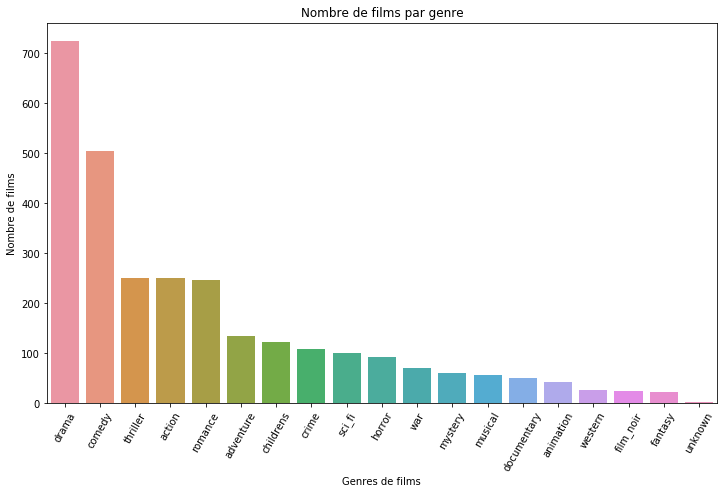

In [25]:
# Genre de film le plus commun du dataset 

generes = ['unknown', 'action',
       'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary',
       'drama', 'fantasy', 'film_noir', 'horror', 'musical', 'mystery',
       'romance', 'sci_fi', 'thriller', 'war', 'western']

plt.figure(figsize=(12,7))
genere_counts = movie_df.loc[:,generes].sum().sort_values(ascending=False)
sns.barplot(x=genere_counts.index, y=genere_counts.values)
plt.xticks(rotation=60)
plt.ylabel('Nombre de films')
plt.xlabel('Genres de films')
plt.title('Nombre de films par genre')

Les genres dramatique et comédie sont les 2 genres de films les plus présents dans le dataset movie_df. A noter que cela ne peut pas être une indication claire de la préférence des personnes car un film peut avoir plus d'un genre, et le drame est le genre le plus commun aux films du dataset.

Text(0.5, 1.0, 'Nombre de films par année de publication')

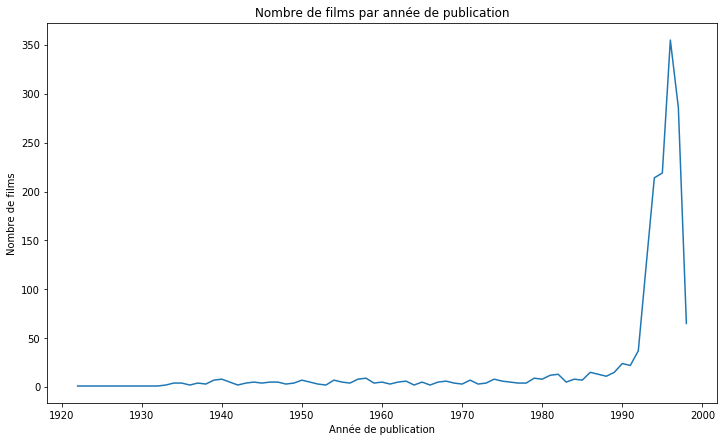

In [16]:
# Année de publication des films

plt.figure(figsize=(12,7))
yearly_release_counts = movie_df.groupby(movie_df.release_date.dt.year).size().sort_values(ascending=False)
sns.lineplot(yearly_release_counts.index, yearly_release_counts.values);
plt.ylabel('Nombre de films')
plt.xlabel('Année de publication')
plt.title('Nombre de films par année de publication')

On peut déduire que les personnes ont surtout regardé des films sortis dans les années 90.

Text(0.5, 1.0, 'Nombre de films par mois de publication')

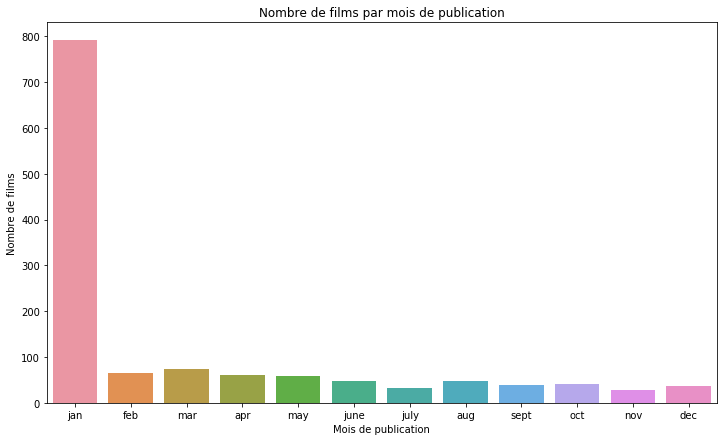

In [17]:
# Mois de publication des films

plt.figure(figsize=(12,7))
monthly_release_counts = movie_df[movie_df.release_date.dt.year > 1990].groupby(movie_df.release_date.dt.month).size()
sns.barplot(['jan', 'feb', 'mar', 'apr', 'may', 'june', 'july', 'aug', 'sept', 'oct', 'nov', 'dec'], monthly_release_counts.values);
plt.ylabel('Nombre de films')
plt.xlabel('Mois de publication')
plt.title('Nombre de films par mois de publication')

Le nombre de films publiés en janvier est trop élevé par rapport aux autres mois. On peut supposer que les créateurs du jeu de données ont considéré le 1er janvier comme le mois et la date de publication par défaut.

Text(0.5, 1.0, 'Nombre de films par jour de publication')

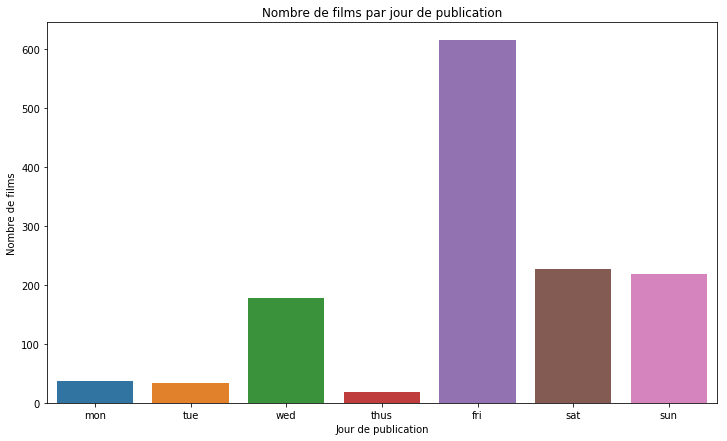

In [18]:
# Jour de publication des films

plt.figure(figsize=(12,7))
weekday_release_counts = movie_df[movie_df.release_date.dt.year > 1990].groupby(movie_df.release_date.dt.dayofweek).size()
sns.barplot(['mon', 'tue', 'wed', 'thus', 'fri', 'sat', 'sun'], weekday_release_counts.values);
plt.ylabel('Nombre de films')
plt.xlabel('Jour de publication')
plt.title('Nombre de films par jour de publication')

La majorité des films ont été publiés le week-end (vendredi majoritairement, samedi, dimanche) et mercredi.

Text(0.5, 1.0, 'Nombre de films notés par genre (Féminin/Masculin)')

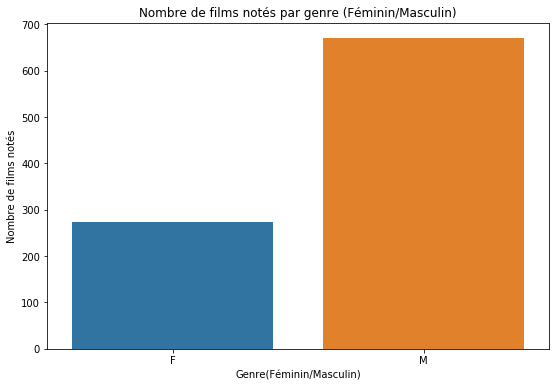

In [19]:
# Le genre (Masculin ou Féminin) ayant noté le plus de films

plt.figure(figsize=(9,6))
sns.barplot(user_df.groupby('gender').size().index, user_df.groupby('gender').size().values)
plt.ylabel('Nombre de films notés')
plt.xlabel('Genre(Féminin/Masculin)')
plt.title('Nombre de films notés par genre (Féminin/Masculin)')

Les hommes ont majoritairement noté plus de films que les femmes.

Text(0.5, 1.0, 'Nombre de films regardés par âge')

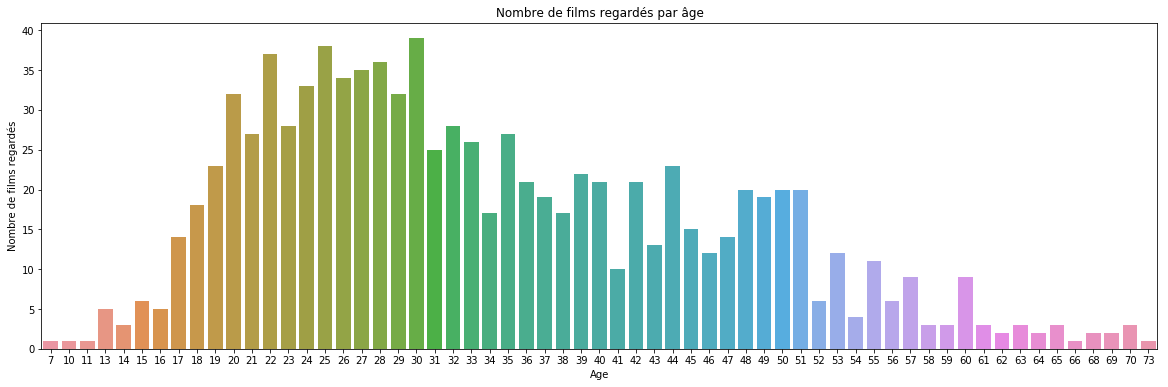

In [20]:
# L'age des personnes ayant regardé le plus de films 

plt.figure(figsize=(20,6))
sns.barplot(user_df.groupby('age').size().index, user_df.groupby('age').size().values)
plt.ylabel('Nombre de films regardés')
plt.xlabel('Age')
plt.title('Nombre de films regardés par âge')

Les personnes ayant regardé le plus de films ont 30 ans, 25 ans et 22 ans.

Text(0.5, 1.0, "Nombre de films regardés par groupe d'âge")

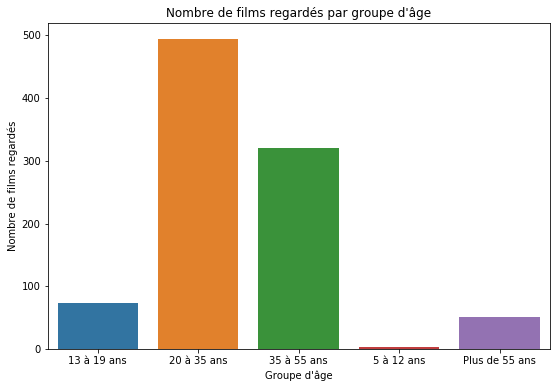

In [21]:
#Le genre des personnes ayant noté le plus de films

user_df['age_group'] = user_df.age.apply(lambda age: '5 à 12 ans' if 5<=age<=12 else ('13 à 19 ans' if 13<=age<=19 else ('20 à 35 ans' if 20<=age<=35 else ('35 à 55 ans' if 35<=age<=55 else 'Plus de 55 ans'))))
plt.figure(figsize=(9,6))
sns.barplot(user_df.groupby('age_group').size().index, user_df.groupby('age_group').size().values)
plt.ylabel('Nombre de films regardés')
plt.xlabel("Groupe d'âge")
plt.title("Nombre de films regardés par groupe d'âge")

Les 2 groupes de personnes ayant regardé le plus de films sont le groupe des 20 à 35 ans, puis celui des 35 à 55 ans. Le groupe des enfants est celui qui regarde le moins de films. Les personnes de plus de 55 ans regardent un légèrement moins de films que les adolescents de 13 à 19 ans.

Text(0.5, 1.0, 'Nombre de films notés par métier des personnes')

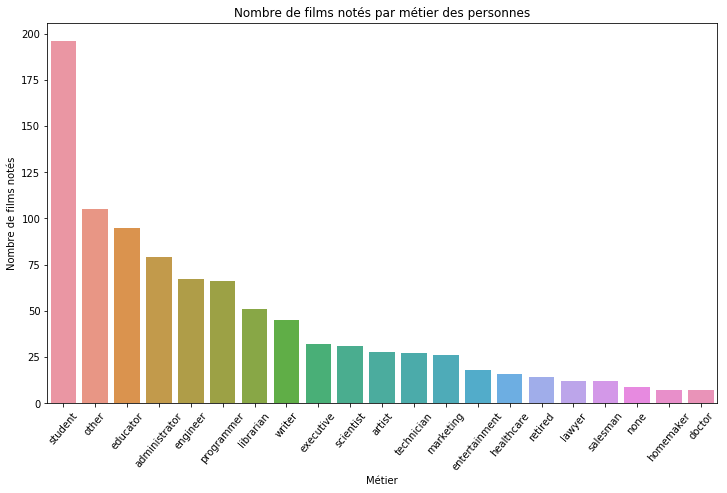

In [28]:
# Le métier des personnes ayant noté le plus de films

plt.figure(figsize=(12,7))
movie_watcher_occupants = user_df.groupby('occupation').size().sort_values(ascending=False)
sns.barplot(movie_watcher_occupants.index, movie_watcher_occupants.values)
plt.title('movie watchers age_group wise')
plt.xticks(rotation=50)
plt.ylabel('Nombre de films notés')
plt.xlabel("Métier")
plt.title("Nombre de films notés par métier des personnes")

Les personnes regardant le plus de films sont étudiants.

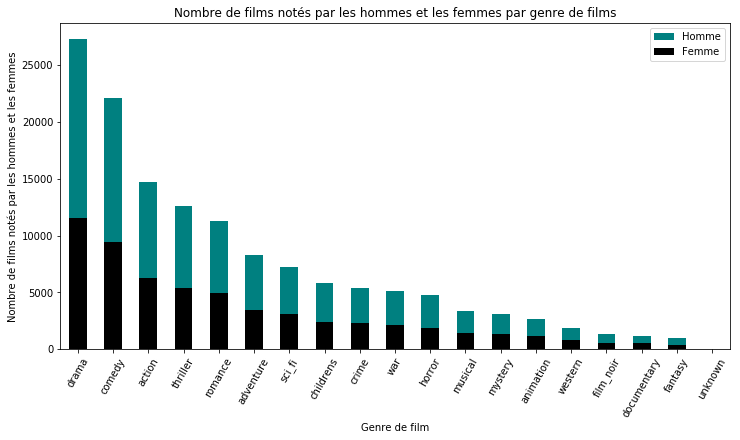

In [27]:
# Nombre de films notées par les hommes et les femmes par genre de films

temp_df = rating_user_movie_df.groupby('gender').sum().loc[:,generes]
temp_df = temp_df.transpose()
plt.figure(figsize=(12, 6))
temp_df.M.sort_values(ascending=False).plot(kind='bar', color='teal', label="Homme")
temp_df.F.sort_values(ascending=False).plot(kind='bar', color='black', label="Femme")
plt.legend()
plt.xticks(rotation=60)
plt.ylabel('Nombre de films notés par les hommes et les femmes')
plt.xlabel("Genre de film")
plt.title("Nombre de films notés par les hommes et les femmes par genre de films")
plt.show()

Les hommes notent plus de films que les femmes et le genre de film le plus noté par les 2 sexes est le genre dramatique.

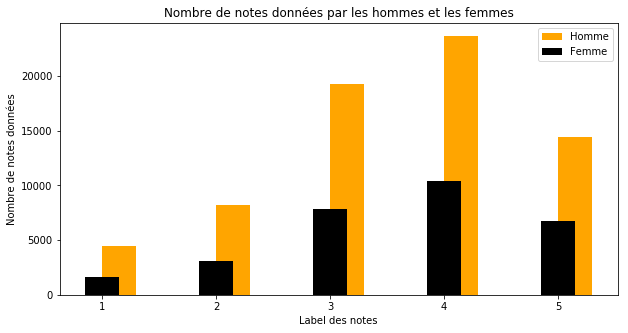

In [24]:
# Nombre de notes données par les hommes et les femmes 

temp_df = rating_user_df.groupby(['gender', 'rating']).size()
plt.figure(figsize=(10, 5))
m_temp_df = temp_df.M.sort_values(ascending=False)
f_temp_df = temp_df.F.sort_values(ascending=False)

plt.bar(x=m_temp_df.index, height=m_temp_df.values, label="Homme", align="edge", width=0.3, color='orange')
plt.bar(x=f_temp_df.index, height=f_temp_df.values, label="Femme", width=0.3, color='black')
plt.legend()
plt.ylabel('Nombre de notes données')
plt.xlabel("Label des notes")
plt.title("Nombre de notes données par les hommes et les femmes")
plt.show()

La note la plus attribuée par les personnes (Hommes et Femmes confondus) est "4", puis, "3" puis "5".

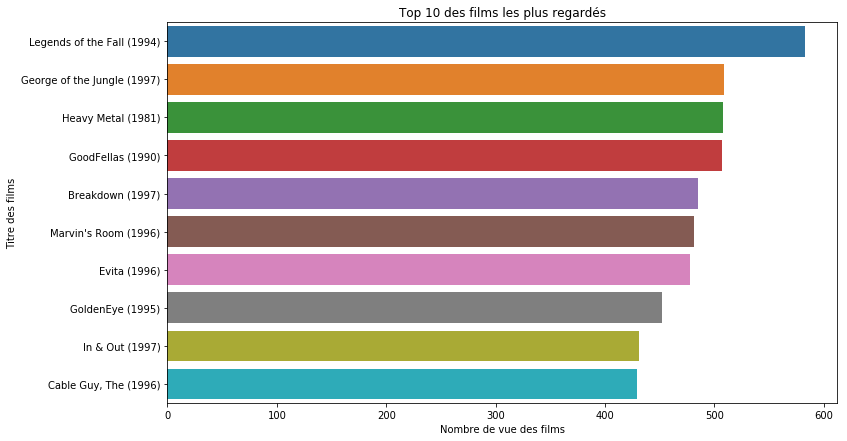

In [25]:
# Top 10 des films les plus regardés

def draw_horizontal_movie_bar(movie_titles, ratings_count, title=''):
    plt.figure(figsize=(12, 7))
    sns.barplot(y=movie_titles, x=ratings_count, orient='h')
    plt.title(title)
    plt.ylabel('Titre des films')
    plt.xlabel('Nombre de vue des films')
    plt.show()

top_ten_rated_movies = rating_movie_df.groupby('movie_id').size().sort_values(ascending=False)[:10]
top_ten_movie_titles = movie_df.iloc[top_ten_rated_movies.index].movie_title

draw_horizontal_movie_bar(top_ten_movie_titles.values, top_ten_rated_movies.values, 'Top 10 des films les plus regardés')


Les 3 films les plus regardés sont : <br>
- Legends of the Falls (1994)
- George of the Jungle (1997)
- Heavy Metal (1981)

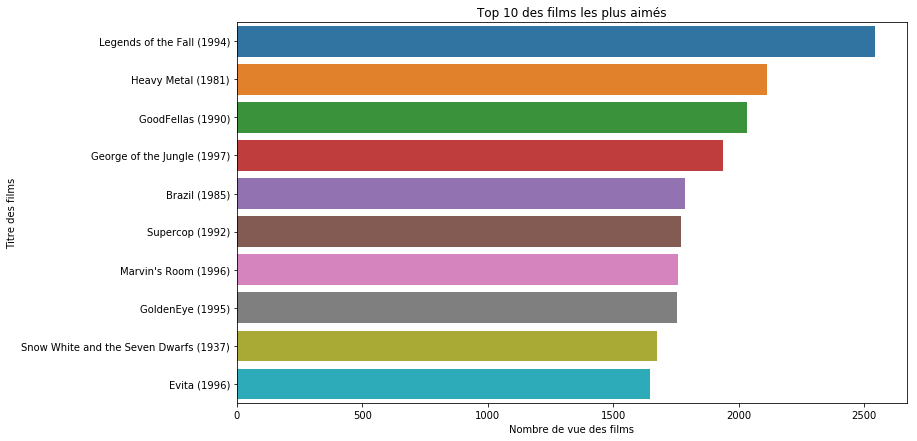

In [26]:
# Top 10 des films les plus aimés

top_ten_most_loved_movies = rating_movie_df.groupby('movie_id').sum().rating.sort_values(ascending=False)[:10]
top_ten_most_loved_movie_titles = movie_df.iloc[top_ten_most_loved_movies.index].movie_title

draw_horizontal_movie_bar(top_ten_most_loved_movie_titles.values, top_ten_most_loved_movies.values, 'Top 10 des films les plus aimés')


Les 3 films les plus aimés sont : <br>
- Legends of the Falls (1994)
- Heavy Metal (1981)
- GoodFellas (1990)

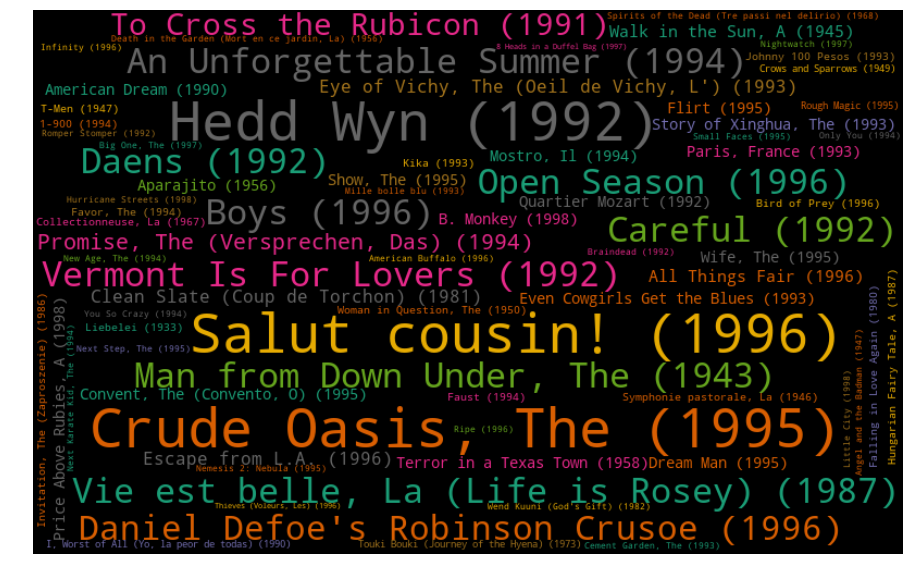

In [27]:
#Les pires films selon la note des personnes (nuage de mots)

movies_ratings_sum = rating_user_movie_df.groupby('movie_id').sum().rating.sort_values()
movies_ratings_sum.index = movie_df.iloc[movies_ratings_sum.index].movie_title
# Will show movies with 0 < total_rating<= 10
lowest_rated_movies = movies_ratings_sum[movies_ratings_sum <= 10]


wordcloud = WordCloud(min_font_size=7, width=800, height=500, random_state=21, max_font_size=50, relative_scaling=0.5, colormap='Dark2')
# Substracted lowest_rated_movies from 11 so that we can have greater font size of least rated movies.
wordcloud.generate_from_frequencies(frequencies=(11-lowest_rated_movies).to_dict())
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Les 3 films les moins bien notés sont :
- Hedd Wyn (1992)
- Salut cousin !(1996)
- The Crude Oasis (1995)

Pour la suite du TP nous utiliserons le dataframe rating_df (relatif au fichier u.data).

## c3 - Construction de la matrice M


La matrice M est de taille  (943, 1682)

La matrice M est de longueur  100000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
user_id      100000 non-null int64
movie_id     100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.1 MB

(Ci-dessus : Infos sur rating_df) None

Le nombre de bytes occupés par les data de la matrice M en mémoire est égal à  800000 soit  0.8 MB
 Apercu de M :  [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


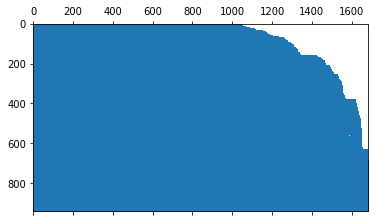

In [4]:
data = rating_df.iloc[:,0:3] # enlever la colonne timestamp car toute colonne de type non-int ou non-float renvoie erreur lors de la conversion des values en matrice
data_shape = (943, 1682) #définir au préalable une taille pour la matrice M
values = data.values
values[:, 0:2] -= 1 #on soustrait -1 à chaque valeur du dataframe df à toutes les lignes des colonnes 0 à 2
M = scipy.sparse.csr_matrix((values[:,2],(values[:,0],values[:,1])),dtype=np.float,shape=data_shape)
print("\nLa matrice M est de taille ",M.shape)
print("\nLa matrice M est de longueur ", len(M.data),"\n")
print("\n(Ci-dessus : Infos sur rating_df)",rating_df.info())
print("\nLe nombre de bytes occupés par les data de la matrice M en mémoire est égal à ",M.data.nbytes, "soit ",M.data.nbytes/1000000,"MB")
print(" Apercu de M : ", M.toarray())
plt.spy(M)

On constate visuellement que la matrice M est bien clairsemée et contient des valeurs nulles (correspondant à la partie blanche du rectangle ci-dessus).


d) La différence entre le dataframe rating_df et la matrice clairsemée compressée M est : <br>
- leurs dimensions (rating_df fait 100000 x 4 et M fait 943 x 1682) <br>
- la matrice M ne contient pas de date, uniquement des données sur les utilisateurs, les films et les notes attribuées par les utilisateurs <br>
- leur type (dataframe versus matrice clairsemée compressée) 
- la place qu'ils occupent en mémoire (rating_df occupe 3.1 MB en mémoire tandis que M occupe 0,8 MB en mémoire)

# Question 2 : Data Pre processing

a) Les matrices sparse ou matrices clairsemées sont des matrices contenant majoritairement des valeurs nulles (à ne pas confondre avec les matrices denses qui contiennent pas ou peu de valeurs nulles). Elles présentent plusieurs avantages tels que :
- le stockage efficace de données présentant beaucoup de valeurs nulles (exemple par compression comme le cas de la matrice M ci-dessus)<br>
- la capacité à effectuer des calculs matriciels complexes. <br>
<br>
Les grandes matrices clairsemées sont courantes en général et en particulier dans l'apprentissage automatique appliqué, comme dans les données qui contiennent des nombres, les encodages de données qui mappent les catégories aux nombres, et même dans des sous-domaines entiers de l'apprentissage automatique tels que le traitement du langage naturel. <br>

b) Découpage de la matrice en 2 (90% apprentissage et 10% test)

In [5]:
ind = np.random.permutation(range(100000))
inda = ind[0:90000] 
indt = ind [90000:]
M = scipy.sparse.csr_matrix((values[:, 2], (values[:, 0], values[:, 1])), dtype =np.float, shape=data_shape)
Ma = scipy.sparse.csr_matrix((values[inda, 2], (values[inda, 0], values[inda, 1])), dtype=np.float, shape=data_shape)
Mt = scipy.sparse.csr_matrix((values[indt, 2], (values[indt, 0], values[indt, 1])), dtype=np.float, shape=data_shape)
print("M est de dimension ",M.shape)
print("Ma est de dimension ",Ma.shape)
print("Mt est de dimension ",Mt.shape)
print("M est de longueur ",len(M.data))
print("Ma est de longueur ",len(Ma.data))
print("Mt est de longueur ",len(Mt.data))

M est de dimension  (943, 1682)
Ma est de dimension  (943, 1682)
Mt est de dimension  (943, 1682)
M est de longueur  100000
Ma est de longueur  90000
Mt est de longueur  10000


c) Calcul des notes moyennes attribuées par les utilisateurs au film sur l'ensemble d'apprentissage

In [6]:
moy = np.sum(Ma)/np.sum(Ma >.5) #Ma >.5 filtre et renvoie les valeurs non nulles
print("La moyenne des notes attribués sur l'ensemble d'apprentissage est égal à ",moy)

La moyenne des notes attribués sur l'ensemble d'apprentissage est égal à  3.528077777777778


d) Calcul l'erreur moyenne de test $E_t$ (lors de la prévision des notes manquantes par la moyenne)

$E_t$ se calcule de la manière suivante : 

$$ E_t = 1/nt \sum_{i=1}^n (M_t(i) - \mu)^2 $$

où : <br>
- $nt$ représente le nombre de notes de l'ensemble de test 
- $M_t$ représente les notes de l'ensemble de test 
- $\mu$ la moyenne des notes de l'ensemble d'apprentissage

In [7]:
Maska = Ma>.5 #renvoie toutes les valeurs de Ma non nulles (strictement supérieures à 0,5), Maska est une matrice binaire qui affiche 0 si la valeur dans Ma est égale à 0 et 1 sinon 
Maskt = Mt>.5 #renvoie toutes les valeurs de Mt non nulles

nt = np.sum(Mt>.5)
na = np.sum(Ma>.5)

err = (1/nt)*np.sum((Mt - Maskt.multiply(moy)).power(2))

print("nt est de longueur",nt,"\n")
print("na est de longueur",na,"\n")

print("L'erreur E_t sur le jeu de données de test est : {0:.4f}".format(err))
print("La racine carrée de l'erreur E_t sur le jeu de données de test : {0:.4f}".format(np.sqrt(err)))

nt est de longueur 10000 

na est de longueur 90000 

L'erreur E_t sur le jeu de données de test est : 1.2420
La racine carrée de l'erreur E_t sur le jeu de données de test : 1.1145


In [8]:
#Visualisation du contenu des matrices
print(Ma.toarray())
print(" ####################################################")
print(Maska.toarray())
print(" ####################################################")
print(Mt.toarray())
print(" ####################################################")
print(Maskt.toarray())

[[5. 0. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
 ####################################################
[[ True False  True ... False False False]
 [ True False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False  True False ... False False False]]
 ####################################################
[[0. 3. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 ####################################################
[[False  True False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]

On constate que Maska et Maskt sont bien des matrices binaires qui affichent : <br>
- TRUE si la valeur dans Ma et Mt est différent de 0 <br>
- FALSE si la valeur dans Ma et Mt est égale à 0 <br>

e) Centrer les données 

Cette action est nécessaire pour augmenter en performance et diminuer l'erreur.

In [9]:
# Centraliser les données 
Ma_norm = Ma - moy * Maska
Mt_norm = Mt - moy * Maskt

In [10]:
#Visualisation du contenu des matrices
print(Ma_norm.toarray())
print(" ####################################################")
print(Mt_norm.toarray())

[[1.47192222 0.         0.47192222 ... 0.         0.         0.        ]
 [0.47192222 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.47192222 0.         ... 0.         0.         0.        ]]
 ####################################################
[[ 0.         -0.52807778  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 1.47192222  0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


# Question 3 : Recommandation en utilisant SVD

La décomposition matricielle, également connue sous le nom de factorisation matricielle, consiste à décrire une matrice donnée en utilisant ses éléments constitutifs.

La méthode de décomposition matricielle la plus connue et la plus utilisée est la décomposition en valeurs singulières, ou SVD. Toutes les matrices ont un SVD, ce qui rend cette méthode plus stable que d'autres méthodes, telles que la décomposition en valeurs propres. La SVD est une méthode de décomposition matricielle souvent utilisée dans un large éventail d'applications, notamment la compression, le débruitage et la réduction des données.<br>
<br>
<strong> Définition : </strong> <br>
Une décomposition en valeurs singulières (SVD : Singular Value Decomposition) est une factorisation de la matrice A tel que : <br>
<br>
$$ A = USV^* $$
<br>
où : <br>
- $U \in \mathbb{C}^{mxm}$ est une matrice unitaire
- $V \in \mathbb{C}^{nxn}$ est une matrice unitaire
- $S \in \mathbb{C}^{mxn}$ est une matrice diagonale et les coefficients $\sigma_1 ≥ \sigma_2 ≥ ...≥ \sigma_p$, où $p=min(m,n)$ <br>
<br>
<strong> Théorème 1 : Existence et unicité de la SVD </strong> <br>
Toute matrice $A \in \mathbb{C}^{mxn}$ possède une SVD. <br>
Les valeurs singulières $\{\sigma_i\}$ sont déterminées de façon unique. <br>
Si $A$ est carrée $(m=n)$, et les valeurs singulières $\{\sigma_j\}$ sont distinctes, les vecteurs d'entrée et de sortie $V_j$ et $U_j$ sont déterminés de façon unique à un facteur complexe unité près. <br>
<br>
<strong> Théorème 2 : Relation entre valeurs singulières et valeurs propres </strong> <br>
Les valeurs singulières d'une matrice A sont les racines carrées des valeurs propres non-nulles de $A^*A$ et $AA^*$ <br>
<br>
<strong> Théorème 3 : Vecteurs propres </strong> <br>
Les colonnes de U sont les vecteurs propres orthogonaux de $AA^*$ et les colonnes de V sont les vecteurs propres orthogonaux de $A^*A$ à unité complexe près.

Afin d'implémenter la formule de la SVD, nous utiliserons la formule ci-dessous :

$$Y = U_1 * S_1 * V_1^t + B $$ 
avec $$||B||^2 = ||Y - U_1*S_1*V_1^t||^2 ⇔ ||B||^2 = ||Y||^2 - S(1)^2$$

où : <br>
- $Y$ représente la matrice à décomposer (de taille mxn)
- $U_1$ représente une matrice (de taille m x m)
- $S_1$ représente une matrice diagonale (de taille m x n)
- $V^t$ est la transposition d'une matrice V (de taille nxn) où t est un exposant.
- $B$ représente le bruit ou l'erreur de reconstruction de la matrice Y


<strong> Exemple d'implémentation de la SVD : </strong>

In [11]:
def construction_random_full_matrix(n,p) :
    n = n
    p = p
    Y = np.random.randn(n,p)
    print("La matrice Y est de dimension ",np.shape(Y))
    U,dS,Vt = np.linalg.svd(Y)   # par default : full_matrices=True
    S = np.diag(dS)
    B = np.max(Y - U[:,0:p]@S@Vt)
    print("Les matrices U,S,Vt sont respectivement de dimension ",np.shape(U),np.shape(dS),np.shape(Vt))
    #print(U.T@U)     # U est orthogonale
    print("L'erreur de reconstruction de la matrice est égal à :",np.max(Y - U[:,0:p]@S@Vt))
    return(U,dS,Vt,B)

In [12]:
construction_random_full_matrix(8,4)

La matrice Y est de dimension  (8, 4)
Les matrices U,S,Vt sont respectivement de dimension  (8, 8) (4,) (4, 4)
L'erreur de reconstruction de la matrice est égal à : 1.7763568394002505e-15


(array([[ 0.10462925, -0.29105233,  0.34509275, -0.11439626,  0.48633409,
         -0.27929769,  0.29068308,  0.61085273],
        [ 0.23163662, -0.50388374,  0.16152699,  0.75097741, -0.1362502 ,
          0.24192272, -0.14770179,  0.05900064],
        [ 0.69785702,  0.41379234,  0.41410454,  0.05277415,  0.11257318,
         -0.2349084 , -0.18640052, -0.25476257],
        [ 0.29366601,  0.2901883 , -0.46793007,  0.0695144 ,  0.45750635,
          0.54730817, -0.09487704,  0.29647982],
        [-0.33249307,  0.06811425, -0.17164305,  0.44501445,  0.61306612,
         -0.3622105 ,  0.00749917, -0.3875653 ],
        [-0.41656275,  0.37617293,  0.62750076,  0.1352446 ,  0.09613997,
          0.49070996,  0.15124307, -0.00273326],
        [ 0.24018919,  0.09953562, -0.16035361,  0.18039061, -0.15266917,
          0.03236719,  0.90702466, -0.16461624],
        [-0.14277968,  0.4999034 , -0.12428631,  0.40799428, -0.33842194,
         -0.36837165, -0.06569837,  0.54153558]]),
 array([3.2208

In [13]:
def construction_random_reduced_matrix(n,p) :
    n = n
    p = p
    Y = np.random.randn(n,p)
    print("La matrice Y est de dimension ",np.shape(Y))
    U,dS,Vt = np.linalg.svd(Y,full_matrices=False)   # par default : full_matrices=True
    S = np.diag(dS)
    B = np.max(Y - U[:,0:p]@S@Vt)
    print("Les matrices U,S,Vt sont respectivement de dimension ",np.shape(U),np.shape(dS),np.shape(Vt))
    #print(U.T@U)     # U est orthogonale
    print("L'erreur de reconstruction de la matrice est égal à :",np.max(Y - U[:,0:p]@S@Vt))
    return(U,dS,Vt,B)

In [14]:
construction_random_reduced_matrix(8,4)

La matrice Y est de dimension  (8, 4)
Les matrices U,S,Vt sont respectivement de dimension  (8, 4) (4,) (4, 4)
L'erreur de reconstruction de la matrice est égal à : 6.661338147750939e-16


(array([[-0.44035364,  0.27343303, -0.51061527,  0.05230052],
        [ 0.58702126,  0.15840401,  0.25370952, -0.00236267],
        [-0.50021246, -0.0783097 ,  0.45045043, -0.6213022 ],
        [ 0.16002025,  0.45319619, -0.34884598, -0.24668925],
        [-0.22077438,  0.43350497, -0.00702925, -0.08263402],
        [-0.21564633,  0.42991464,  0.25893932,  0.55683131],
        [ 0.07779514, -0.33798054, -0.53206765, -0.15250804],
        [ 0.29048061,  0.44904271,  0.01046154, -0.45851814]]),
 array([3.51361367, 2.69657964, 1.7067079 , 1.54304941]),
 array([[-0.54727829,  0.67945613,  0.37529162,  0.31302085],
        [ 0.41791624,  0.72750914, -0.43446985, -0.32758574],
        [-0.1214121 ,  0.00209535,  0.52287526, -0.8437157 ],
        [-0.71490671, -0.09521257, -0.6300743 , -0.28783563]]),
 6.661338147750939e-16)

On constate que la taille de U est égale à (8,8) en construction full matrice et (8,4) en construction reduced matrice. Par conséquent, ue construction de matrice en reduced matrix sera à privilégier afin de ne pas saturer la mémoire.

Revenons maintenant à notre TP. Nous allons maintenant prédire les valeurs de test manquantes à l'aide du SVD avec un nombre croissant de composants (jusqu'à 20), puis évaluer les performances de cette approche sur la matrice de test. Nous allons ensuite tracer les performances résultantes en fonction du nombre de facteurs de la SVD utilisés pour effectuer la reconstruction de la matrice.

## Avec Matplotlib

Le nombre optimal de facteurs d est  13 et son erreur associée (MSE) est égale à  1.0242622570180873


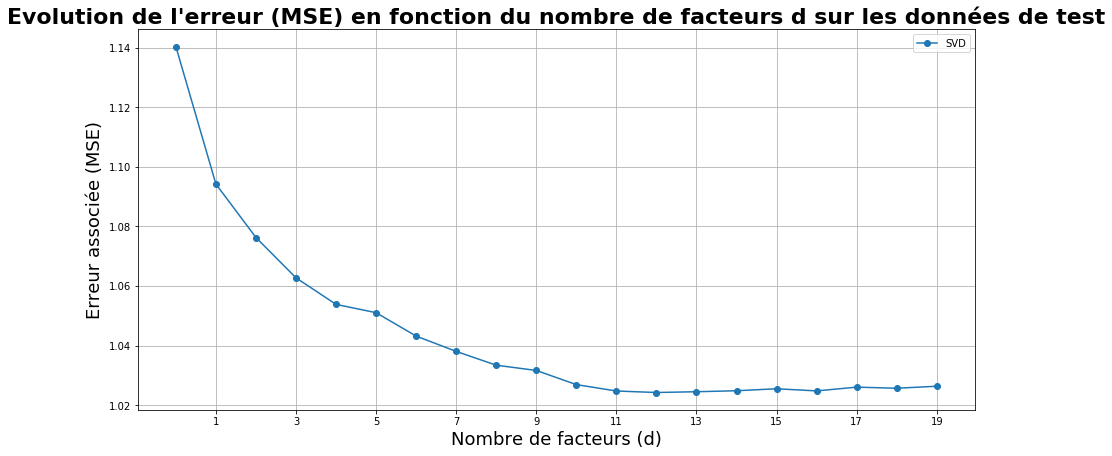

CPU times: user 780 ms, sys: 81.5 ms, total: 861 ms
Wall time: 467 ms


In [15]:
%%time
U, D, Vt = scipy.sparse.linalg.svds(Ma_norm,k=20)
U = U[:, ::-1] #affiche les éléments du dernier au premier (ie par ordre décroissant d'indices)
D = D[::-1]
Vt = Vt[::-1, :]
p = 20
err = np.zeros(p)

malistex1 = []
malistey1 = []

for i in range(1,p+1):
    Mh = np.dot(np.dot(U[:,0:i],np.diag(D[0:i])),Vt[0:i,:])
    Merr = Mt_norm  - Maskt.multiply(Mh)
    err[i-1] = np.sum(Merr.power(2))/nt
    #print("Le nombre optimal de facteurs d de la SVD est : %d, et sa MSE est égale à : %.3f " %(np.argmin(err),err[np.argmin(err)]))
    #print("Le nombre de valeurs singulières d de la SVD est : %d, et sa MSE est égale à : %.4f " %(i,err[i-1]))
    malistex1.append(i)
    malistey1.append(err[i-1])  
dfmalistex1 = pd.DataFrame(malistex1)
dfmalistey1 = pd.DataFrame(malistey1)
frames = [dfmalistex1,dfmalistey1]
dfmaliste1 = pd.concat(frames, axis=1)
dfmaliste1.columns = ['d','erreur']
dfopt1 = dfmaliste1[dfmaliste1.erreur==min(dfmaliste1.erreur)]
print("Le nombre optimal de facteurs d est ",dfopt1.iloc[0,0],"et son erreur associée (MSE) est égale à ",dfopt1.iloc[0,1])

fig = plt.figure(figsize=(15, 7))
plt.plot(err,'o-',label ="SVD")
plt.xticks(np.arange(1, p, step=2))
plt.title("Evolution de l'erreur (MSE) en fonction du nombre de facteurs d sur les données de test", fontsize=22, fontweight="bold")
plt.xlabel('Nombre de facteurs (d)', fontsize=18)
plt.ylabel('Erreur associée (MSE)', fontsize=18)
plt.grid(True)
plt.legend()
plt.show()    

## Avec Plotly

In [42]:
%%time
U, D, Vt = scipy.sparse.linalg.svds(Ma_norm,k=20)
U = U[:, ::-1] #affiche les éléments du dernier au premier (ie par ordre décroissant d'indices)
D = D[::-1]
Vt = Vt[::-1, :]
p = 20
err = np.zeros(p)

malistex1 = []
malistey1 = []

for i in range(1,p+1):
    Mh = np.dot(np.dot(U[:,0:i],np.diag(D[0:i])),Vt[0:i,:])
    Merr = Mt_norm  - Maskt.multiply(Mh)
    err[i-1] = np.sum(Merr.power(2))/nt
    #print("Le nombre optimal de facteurs d de la SVD est : %d, et sa MSE est égale à : %.3f " %(np.argmin(err),err[np.argmin(err)]))
    #print("Le nombre de valeurs singulières d de la SVD est : %d, et sa MSE est égale à : %.4f " %(i,err[i-1]))
    malistex1.append(i)
    malistey1.append(err[i-1])
    
dfmalistex1 = pd.DataFrame(malistex1)
dfmalistey1 = pd.DataFrame(malistey1)
frames = [dfmalistex1,dfmalistey1]
dfmaliste1 = pd.concat(frames, axis=1)
dfmaliste1.columns = ['d','erreur']
dfopt1 = dfmaliste1[dfmaliste1.erreur==min(dfmaliste1.erreur)]
print("Le nombre optimal de facteurs d est ",dfopt1.iloc[0,0],"et son erreur associée (MSE) est égale à ",dfopt1.iloc[0,1])

#Line Plot with Plotly
trace1 = go.Scatter(
                x = dfmaliste1.d.values,
                y = dfmaliste1.erreur.values,
                mode = "lines+markers",
                name = "SVD",
                marker = dict(color = 'rgb(3,183,255)'),
                text = ['d,MSE'])
data = [trace1]
layout = go.Layout(title = "Evolution de l'erreur (MSE) en fonction du nombre de facteurs d sur le jeu de données de test",
              xaxis= dict(title= 'Nombre de facteurs (d)',ticklen= 10,zeroline= False),
              yaxis= dict(title= 'Erreur associée (MSE)',ticklen= 10,zeroline= False),
              showlegend = True,     
             )
fig = go.Figure(data = data, layout = layout)
fig.show()  

Le nombre optimal de facteurs d est  13 et son erreur associée (MSE) est égale à  1.0242622570180868


CPU times: user 492 ms, sys: 96.7 ms, total: 589 ms
Wall time: 331 ms


On constate que le temps d'execution avec plotly est beaucoup plus rapide qu'avec matplotlib. De plus, le fait que le graphique soit dynamique (plotly s'appuis sur une librarie JavaScript) nous permet de nous positionner sur un point quelconque de la courbe et de visualiser instantanément la valeur du tuple (d,MSE) relative à ce point. Le graphique matplotlib ci-dessus ne permet pas de déterminer visuellement si le d optimal est 12 ou 13 alors que plotly donne cette information immédiatement. <br> Plotly propose également de nombreuses fonctionnalités que ne possède pas Matplotlib telles que la possibilité de zoomer sur le graphique par exemple pour avoir plus de détails, ou la possibilité de créer un graphique intéractif.

b) Dans ce cas, le nombre optimal de facteurs est d=13.

# Question 4 : Weighted SVD 

a) Utilisation de l'approche proposée par Marlin ou Srebro

Loop
$$F = WM+(1−W)Z^k $$
$$U,V = svd(F)$$
$$Z^k+1 = UV^⊤$$

Pour plus de détails : 
- Marlin, B. (2004). Collaborative filtering: A machine learning perspective (pp. 2239-
2239). Toronto: University of Toronto.
- Srebro, N., & Jaakkola, T. (2003). Weighted low-rank approximations. In Proceedings
of the 20th International Conference on Machine Learning (ICML-03) (pp. 720-727).

Revenons à notre TP. Nous allons maintenant appliquer la wSVD sur nos données afin de prédire les valeurs de test manquantes à l'aide du SVD avec un nombre croissant de composants (jusqu'à 20), puis évaluer les performances de cette approche sur la matrice de test. Nous allons ensuite tracer les performances résultantes en fonction du nombre de facteurs de la wSVD pour effectuer la reconstruction de la matrice.

### Avec Matplotlib

Le nombre optimal de facteur d est  5 et son erreur associée (MSE) est égale à  0.8445127063553942


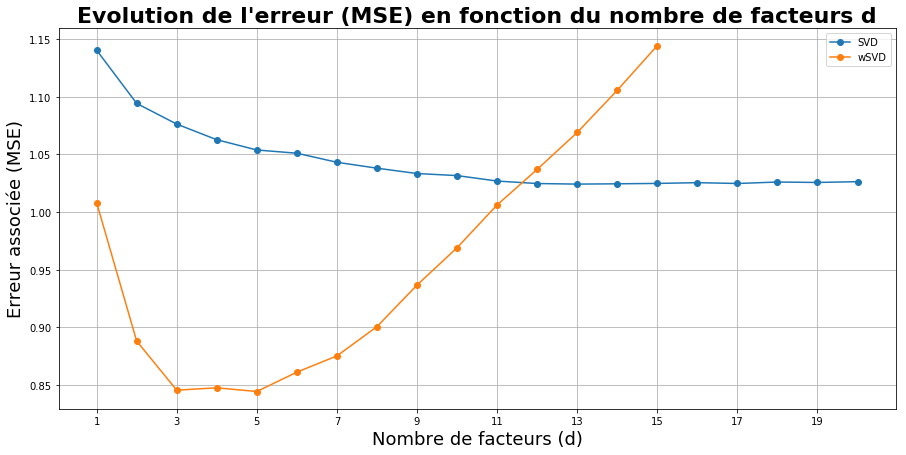

CPU times: user 2min 26s, sys: 12.3 s, total: 2min 38s
Wall time: 1min 20s


In [32]:
%%time

k = 15
nb_iter_max = 30 # 10

malistex2 = []
malistey2 = []

Mest = 0*Ma_norm; # initial guess is 0
errw = np.zeros(k)
un = np.ones((943, 1682))
un_m_Maska = scipy.sparse.csr_matrix(un-Maska)
for i in range(1,k+1):
    for ii in range(1,30):
        Y = Ma_norm + un_m_Maska.multiply(Mest);
        U, D, Vt = scipy.sparse.linalg.svds(Y,k=i)
        Mest = np.dot(np.dot(U,np.diag(D)),Vt)

    Merr = Mt_norm  - Maskt.multiply(Mest)
    errw[i-1] = np.sum(Merr.power(2))/nt
    #print("Le nombre optimal de facteurs d de la SVD est : %d, et sa MSE est égale à : %.3f " %(np.argmin(errw),err[np.argmin(errw)]))
    #print("Le nombre de valeurs singulières d de la SVD est : %d, et sa MSE est égale à : %.3f " %(i,errw[i-1]))
    malistex2.append(i)
    malistey2.append(errw[i-1])
    
dfmalistex2 = pd.DataFrame(malistex2)
dfmalistey2 = pd.DataFrame(malistey2)
frames = [dfmalistex2,dfmalistey2]
dfmaliste2 = pd.concat(frames, axis=1)
dfmaliste2.columns = ['d','erreur']
dfopt2 = dfmaliste2[dfmaliste2.erreur==min(dfmaliste2.erreur)]
print("Le nombre optimal de facteur d est ",dfopt2.iloc[0,0],"et son erreur associée (MSE) est égale à ",dfopt2.iloc[0,1])

fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,k+6),err, 'o-',label="SVD")
plt.plot(range(1,k+1),errw, 'o-',label="wSVD")
plt.title("Evolution de l'erreur (MSE) en fonction du nombre de facteurs d", fontsize=22, fontweight="bold")
plt.xticks(np.arange(1, k+5, step=2))
plt.xlabel('Nombre de facteurs (d)', fontsize=18)
plt.ylabel('Erreur associée (MSE)', fontsize=18)
plt.grid(True)
plt.legend()
plt.show()

### Avec Plotly

In [37]:
%%time

k = 15
nb_iter_max = 30 # 10

malistex2 = []
malistey2 = []

Mest = 0*Ma_norm; # initial guess is 0
errw = np.zeros(k)
un = np.ones((943, 1682))
un_m_Maska = scipy.sparse.csr_matrix(un-Maska)

for i in range(1,k+1):
    for ii in range(1,30):
        Y = Ma_norm + un_m_Maska.multiply(Mest);
        U, D, Vt = scipy.sparse.linalg.svds(Y,k=i)
        Mest = np.dot(np.dot(U,np.diag(D)),Vt)

    Merr = Mt_norm  - Maskt.multiply(Mest)
    errw[i-1] = np.sum(Merr.power(2))/nt
    malistex2.append(i)
    malistey2.append(errw[i-1])
    
dfmalistex2 = pd.DataFrame(malistex2)
dfmalistey2 = pd.DataFrame(malistey2)
frames = [dfmalistex2,dfmalistey2]
dfmaliste2 = pd.concat(frames, axis=1)
dfmaliste2.columns = ['d','erreur']
dfopt2 = dfmaliste2[dfmaliste2.erreur==min(dfmaliste2.erreur)]
print("Le nombre optimal de facteurs d est ",dfopt2.iloc[0,0],"et son erreur associée (MSE) est égale à ",dfopt2.iloc[0,1])

#Line Plot with Plotly
trace1 = go.Scatter(
                x = dfmaliste1.d.values,
                y = dfmaliste1.erreur.values,
                mode = "lines+markers",
                name = "SVD",
                marker = dict(color = 'rgb(3,183,255)'),
                text = ['d,MSE'])
trace2 = go.Scatter(
                x = dfmaliste2.d.values,
                y = dfmaliste2.erreur.values,
                mode = "lines+markers",
                name = "wSVD",
                marker = dict(color = 'rgb(255,133,3)'),
                text = ['d,MSE'])
data = [trace1,trace2]
layout = go.Layout(title = "Evolution de l'erreur (MSE) en fonction du nombre de facteurs d sur le jeu de données de test",
              xaxis= dict(title= 'Nombre de facteurs (d)',ticklen= 10,zeroline= False),
              yaxis= dict(title= 'Erreur associée (MSE)',ticklen= 10,zeroline= False),
              showlegend = True,     
             )
fig = go.Figure(data = data, layout = layout)
fig.show()

Le nombre optimal de facteurs d est  5 et son erreur associée (MSE) est égale à  0.8445127063553942


CPU times: user 2min 27s, sys: 13.2 s, total: 2min 40s
Wall time: 1min 20s


La wSVD donne un meilleur résultat par rapport au SVD.

# Question 5 : Résolution du problème de la SVD pondérée pénalisée (wSVD ALS)

Dans cette partie, il nous est demandé de résoudre le problème de la SVD pondérée pénalisée wSVD ALS suivant : <br>
$$min_{U,V} ||M-UV^T||_W^2 + \lambda||U||^2$$

avec  $\lambda=5$  en implémentant le moindre carré alterné pénalisé (ALS) décrit comme suit:
- Initialiser $𝑈$ et $𝑉$ avec le SVD sur la matrice complète et calculer la séquence suivante <br>
- loop : <br>

$$compute U^* = argmin_U ||M-UV^T||_W^2 + \lambda ||U||^2 $$ $$\mbox{(avec V fixé)}$$

$$compute V^* = argmin_V ||M-UV^T||_W^2 + \lambda ||V||^2 $$ $$\mbox{(avec U fixé)}$$

Pour plus de détails :
Y. Hu, Y. Koren, and C. Volinsky. Collaborative filtering for implicit feedback datasets. In Proc. of ICDM'08, pages 263--272, Pisa, Italy, 2008.

Plus de détails sur les formules mathématiques : <br>
Lien collab : https://colab.research.google.com/drive/19h5N4sSnfd3nldYGQFeGHpBknr9uR2wo?usp=sharing#scrollTo=NAEOQMH2HfKY 

Revenons maintenant à notre TP et implémentons la wSVD ALS.

### Avec Matplotlib

Le nombre optimal de facteurs est  4 et son erreur associée (MSE) est égale à  0.8325637554611245


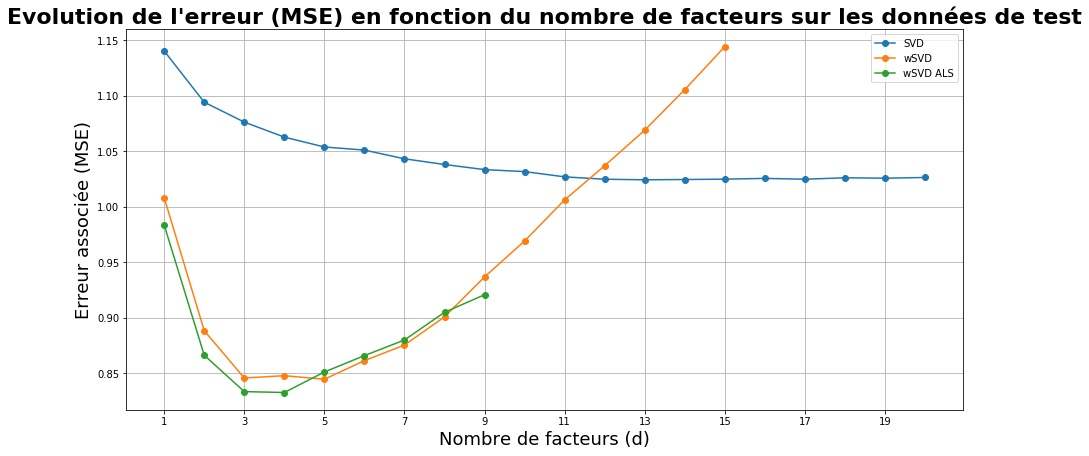

CPU times: user 8min 12s, sys: 3.14 s, total: 8min 16s
Wall time: 8min 12s


In [35]:
%%time
n,p = Ma_norm.shape
lam = 2
Kmax = 10 #20 ICI
err_als = np.zeros(Kmax-1)
malistex3 = []
malistey3 = []

for k in range(1,Kmax):
    I = np.eye(k)
    erri = np.zeros((20+1,)) #40 ici
    U, D, Vt = scipy.sparse.linalg.svds(Ma_norm,k=k)
    Vt = np.dot(np.diag(D),Vt)

    Merr = Mt_norm  - Maskt.multiply(U@Vt)
    erri[0] = np.sum(Merr.power(2))/nt  

    for nb in range(0,20): #40 ICI
        for j in range(0,p):
            indj = Maska[:,j].nonzero()[0]
            Vt[:,j] = np.linalg.solve(U[indj,:].T@U[indj,:] + lam*I,U[indj,:].T@Ma_norm[indj,j]).T

#        Merr = Mt_norm  - Maskt.multiply(U@Vt)
#        erri1 = np.sum(Merr.power(2))/nt  
#        print(erri1)
  
        for i in range(0,n):
            indi = Maska[i,:].nonzero()[1]
            U[i,:] = np.linalg.solve(Vt[:,indi]@Vt[:,indi].T + lam*I,Vt[:,indi]@Ma_norm[i,indi].T).T

    Merr = Mt_norm  - Maskt.multiply(U@Vt)
    erri[nb+1] = np.sum(Merr.power(2))/nt  
    #print(erri[nb+1])
    err_als[k-1] = erri[nb+1]
    
    malistex3.append(k)
    malistey3.append(err_als[k-1])
    
dfmalistex3 = pd.DataFrame(malistex3)
dfmalistey3 = pd.DataFrame(malistey3)
frames = [dfmalistex3,dfmalistey3]
dfmaliste3 = pd.concat(frames, axis=1)
dfmaliste3.columns = ['d','erreur']
dfopt3 = dfmaliste3[dfmaliste3.erreur==min(dfmaliste3.erreur)]
print("Le nombre optimal de facteurs est ",dfopt3.iloc[0,0],"et son erreur associée (MSE) est égale à ",dfopt3.iloc[0,1])

#print("Le nombre optimal de facteurs d de la ALS est : %d, et sa MAE est égale à : %.3f " %(np.argmin(err_als),err[np.argmin(err_als)]))    
fig = plt.figure(figsize=(15, 7))
p = 20
plt.plot(range(1,len(err)+1),err, 'o-',label="SVD")
plt.plot(range(1,len(errw)+1),errw, 'o-',label="wSVD")
plt.plot(range(1,len(err_als)+1),err_als, 'o-',label="wSVD ALS")
plt.grid(True)
plt.xticks(np.arange(1, p, step=2))
#plt.legend(['SVD','wSVD','WSVD ALS'])
plt.title("Evolution de l'erreur (MSE) en fonction du nombre de facteurs sur les données de test", fontsize=22, fontweight="bold")
plt.xlabel('Nombre de facteurs (d)', fontsize=18)
plt.ylabel('Erreur associée (MSE)', fontsize=18)
plt.legend()
plt.show()

### Avec Plotly

In [36]:
%%time

n,p = Ma_norm.shape
lam = 2
Kmax = 10 #20 ICI
err_als = np.zeros(Kmax-1)
malistex3 = []
malistey3 = []

for k in range(1,Kmax):
    I = np.eye(k)
    erri = np.zeros((20+1,)) #40 ici
    U, D, Vt = scipy.sparse.linalg.svds(Ma_norm,k=k)
    Vt = np.dot(np.diag(D),Vt)

    Merr = Mt_norm  - Maskt.multiply(U@Vt)
    erri[0] = np.sum(Merr.power(2))/nt  

    for nb in range(0,20): #40 ICI
        for j in range(0,p):
            indj = Maska[:,j].nonzero()[0]
            Vt[:,j] = np.linalg.solve(U[indj,:].T@U[indj,:] + lam*I,U[indj,:].T@Ma_norm[indj,j]).T

#        Merr = Mt_norm  - Maskt.multiply(U@Vt)
#        erri1 = np.sum(Merr.power(2))/nt  
#        print(erri1)
  
        for i in range(0,n):
            indi = Maska[i,:].nonzero()[1]
            U[i,:] = np.linalg.solve(Vt[:,indi]@Vt[:,indi].T + lam*I,Vt[:,indi]@Ma_norm[i,indi].T).T

    Merr = Mt_norm  - Maskt.multiply(U@Vt)
    erri[nb+1] = np.sum(Merr.power(2))/nt  
    #print(erri[nb+1])
    err_als[k-1] = erri[nb+1]
    
    malistex3.append(k)
    malistey3.append(err_als[k-1])
    
dfmalistex3 = pd.DataFrame(malistex3)
dfmalistey3 = pd.DataFrame(malistey3)
frames = [dfmalistex3,dfmalistey3]
dfmaliste3 = pd.concat(frames, axis=1)
dfmaliste3.columns = ['d','erreur']
dfopt3 = dfmaliste3[dfmaliste3.erreur==min(dfmaliste3.erreur)]
print("Le nombre optimal de facteurs d est ",dfopt3.iloc[0,0],"et son erreur associée (MSE) est égale à ",dfopt3.iloc[0,1])

#Line Plot with Plotly
trace1 = go.Scatter(
                x = dfmaliste1.d.values,
                y = dfmaliste1.erreur.values,
                mode = "lines+markers",
                name = "SVD",
                marker = dict(color = 'rgb(3,183,255)'),
                text = ['d,MSE'])
trace2 = go.Scatter(
                x = dfmaliste2.d.values,
                y = dfmaliste2.erreur.values,
                mode = "lines+markers",
                name = "wSVD",
                marker = dict(color = 'rgb(255,133,3)'),
                text = ['d,MSE'])
trace3 = go.Scatter(
                x = dfmaliste3.d.values,
                y = dfmaliste3.erreur.values,
                mode = "lines+markers",
                name = "wSVD ALS",
                marker = dict(color = 'rgb(78,255,3)'),
                text = ['d,MSE'])
data = [trace1,trace2,trace3]
layout = go.Layout(title = "Evolution de l'erreur (MSE) en fonction du nombre de facteurs d sur le jeu de données de test",
              xaxis= dict(title= 'Nombre de facteurs (d)',ticklen= 10,zeroline= False),
              yaxis= dict(title= 'Erreur associée (MSE)',ticklen= 10,zeroline= False),
              showlegend = True,     
             )
fig = go.Figure(data = data, layout = layout)
aPlot = py.offline.plot(fig, config={"displayModeBar": False}, 
                               show_link=False, 
                               include_plotlyjs=False, 
                               output_type='div')
fig.show()

Le nombre optimal de facteurs d est  4 et son erreur associée (MSE) est égale à  0.8325637554611245


CPU times: user 7min 59s, sys: 2.03 s, total: 8min 1s
Wall time: 7min 55s


La méthode des moindres carrés ALS donne un meilleur résultat par rapport à la SVD simple et la wSVD.

# SVD avec Scikit et la librairie Surprise 

Lien documentation : https://surprise.readthedocs.io/en/stable/getting_started.html#

## Méthode 1 : split train test automatique

Movielens-100K fournit déjà 5 fichiers de train et de test (u1.base, u1.test… u5.base, u5.test). Surprise peut gérer ce cas en utilisant un objet surprise.model_selection.split.PredefinedKFold qui détecte automatiquement les extensions de ces fichiers et répartie par conséquent automatiquement les données en 2 ensembles d'apprentissage et de test. C'est le cas ci-dessous.

In [38]:
%%time
#!pip install scikit-surprise
from surprise import SVD 
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MSE'], cv=5, verbose=True)

Evaluating RMSE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9390  0.9355  0.9291  0.9443  0.9340  0.9364  0.0051  
MSE (testset)     0.8817  0.8751  0.8632  0.8918  0.8723  0.8768  0.0095  
Fit time          5.31    5.32    5.31    5.57    7.09    5.72    0.69    
Test time         0.38    0.14    0.21    0.20    0.23    0.23    0.08    
CPU times: user 30.5 s, sys: 325 ms, total: 30.8 s
Wall time: 31.1 s


## Méthode 2 : split train test à définir soi-même

Il est aussi possible de définir soi-même la répartition des données dans l'ensemble d'apprentissage et de test. Dans le cas ci-dessous nous allons choisir la répartition suivante : 90%apprentissage et 10% test.

In [39]:
%%time
import random

from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV


# Load the full dataset.
data = Dataset.load_builtin('ml-100k')
raw_ratings = data.raw_ratings

# shuffle ratings if you want
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A

# Select your best algo with grid search.
print('Grid Search...')
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=10) #tester plusieurs valeurs de cv
grid_search.fit(data)

algo = grid_search.best_estimator['rmse']

# retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on A
predictions = algo.test(trainset.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(predictions)

# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictions)

Grid Search...
Biased accuracy on A,   RMSE: 0.8378
Unbiased accuracy on B, RMSE: 0.9444
CPU times: user 1min 31s, sys: 317 ms, total: 1min 32s
Wall time: 1min 32s


In [40]:
MSE_on_B = np.power(0.9444,2)
print("MSE", MSE_on_B)

MSE 0.89189136


# CONCLUSION

On a pu constater que plotly permettait d'afficher un graphique de manière plus rapide et plus précise que matplotlib, ce qui peut être avantageux lorsqu'on travaille sur un gros jeu de données et qu'on a besoin beaucoup de visualisations lors de la phase d'analyse des données.<br>
On a aussi pu utiliser plusieurs variantes de la SVD pour calculer l'erreur associée (MSE). Voici ci-dessous un tableau récapitulatif des résultats obtenus : <br>

In [44]:
from IPython.display import display, HTML

ar = np.array([
    [1.0243, 0.8919, 0.8632, 0.8445,0.8326], 
    [13, '-', '-',5,4], 
    [20, 3, 5,15,10],
    ['861 ms', '-', '-','2min 38s','8min 27s'],
    ['589 ms', '-', '-','2min 40s','8min 1s'],
    ['-', '1min 32s','30.8s','-','-']])

dfsynthese = pd.DataFrame(ar, index = ['MSE', 'd', 'k','CPU Time(Matplotlib)','CPU Time(Plotly)','CPU Time'], columns = ['SVD','Surprise (90% train et 10% test)', 'Surprise (Split train test automatique)','wSVD','ALS'])

display(dfsynthese)

SVD Surprise (90% train et 10% test)  \
MSE                   1.0243                           0.8919   
d                         13                                -   
k                         20                                3   
CPU Time(Matplotlib)  861 ms                                -   
CPU Time(Plotly)      589 ms                                -   
CPU Time                   -                         1min 32s   

                     Surprise (Split train test automatique)      wSVD  \
MSE                                                   0.8632    0.8445   
d                                                          -         5   
k                                                          5        15   
CPU Time(Matplotlib)                                       -  2min 38s   
CPU Time(Plotly)                                           -  2min 40s   
CPU Time                                               30.8s         -   

                           ALS  
MSE                     0.8326  
d                            4  
k                           10  
CPU Time(Matplotlib)  8min 27s  
CPU Time(Plotly)       8min 1s  
CPU Time                     -

La ALS donne le meilleur score, en revanche son temps d'éxecution est très lent. <br>
Pour conclure, il est intéressant de tester différentes variantes de SVD et comparer leurs temps d'exécution afin de choisir lequel utiliser dans le cas de manipulation d'un dataset très volumineux.